## Signature Methods in Finance
### Signature and the Functional Taylor Expansion
#### Appendix: Path Reconstruction


In [6]:
from quantLib import *
from math import factorial as fact
import matplotlib.pyplot as plt
from cycler import cycler as cyc
cols = ["midnightblue",'indianred','tomato','mediumpurple',"darkred","plum","gold","steelblue"]
colCyc = cyc(color = cols)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": "palatino", 
})
# New axis (shorthand notation)
__ = np.newaxis
# Legendre polynomials on [0,1]
from scipy.special import sh_legendre as leg

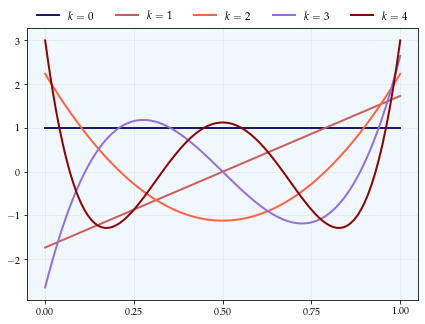

In [7]:
# Horizon and number of time steps
T,N = 1,100                 
ts  = np.linspace(0,T,N+1)  # Time grid (flat)
Ts  = ts[:,__]              # Time grid (column vector)
dt  = T/N                   # Time increments (here constant)

# Legendre polynomials on [0,1] (normalized)
q = lambda k,t: np.sqrt(2*k + 1) * leg(k)(t) #

# Plot: Legendre polynomials
save = 0
fig,ax = plt.subplots(1,1,figsize = (7,5)); ax.set_prop_cycle(colCyc)
ax.set_facecolor("aliceblue")
# Legendre polynomials
K = 5
for k in range(K): 
    ax.plot(ts,q(k,ts),lw = 2,label = r"$k = %d$"%k); plt.grid("off",alpha = 0.2)
plt.xticks(np.linspace(0,1,5))
plt.legend(ncol = K,bbox_to_anchor = (1,1.1),fontsize = 11,frameon=False)
if save: plt.savefig("Figures/LegendrePolynomials.pdf",dpi = 500,bbox_inches ="tight",pad_inches = 0.15)
plt.show()

## Path Reconstruction Algorithm

__Given__ $S^{I_0}(X), \ldots, S^{I_K}(X)$

------

I. For $k=0,\ldots,K$, __compute__:

1. $L^2$ products with  $m_k(t) = t^k$: $\ (X,m_k) =  \sum_{l=0}^{k} (-1)^{l}S^{I_l}(X) \frac{k!}{(k-l)!}$.

2. $L^2$ products with Legendre polynomials: $(X,q_k) = \sum_{l=0}^k a_{k,l} (X,m_k)$

II. __Return__ $X^{K} := \sum_{k\le K} (X,q_k)q_k$

------

In [8]:
# Maximum truncation level
KMax = 10
# Legendre polynomials
Q = np.hstack([q(k,Ts) for k in range(KMax+1)]) 
# Legendre coefficients
a   = [np.sqrt(2*k + 1) * leg(k).coefficients[::-1,__] for k in range(KMax+1)]
    
# Convenient arrays
ks   = np.arange(0,KMax+1)
FACT = np.array([fact(k) for k in ks])[:,__] # factorials

# Integral weights for trapezoidal rule (or use scipy.integrate)
w = 2**(-np.sum(np.eye(N+1)[:,[0,-1]],axis = 1,keepdims = 1))

def reconstructPath(Sig):
    """Path reconstruction Algorithm.
    
    INPUT: S = (S_0,...,S_K): Signature associated to the Legendre words
    I_0 = (1,0), I_1 = (1,0,0), ...  
    
    OUTPUT: Projected path onto the Legendre polynomials up to degree K. 
    """
    # Truncation Level and number of paths
    K,J = np.shape(Sig); K -= 1
    # I.1. L^2 product with monomials
    Sig_ = Sig * (-1)**ks[:K+1,__] # Signatures with alternating sign
    xiM  = np.empty((K+1,J))
    for k in range(K+1):
        xiM[k,:] = FACT[k] * np.sum(Sig_[:k+1] / FACT[:k+1][::-1],axis = 0)
    
    # I.2. L^2 Product with Legendre polynomials
    xiQ = np.vstack([a[k].T @ xiM[:k+1]  for k in range(K+1)])
    
    # II. Projected path     
    return Q[:,:K+1] @ xiQ

### Test 

In [9]:
# Number of simulations and seed
J,seed = 100, 96
# Brownian paths
X = BM(Ts,J,seed = seed)
# Monomials
M   = Ts**ks  
# Signature of Legendre words
Sig = (M[::-1] * w).T @ X * dt / FACT

# Reconstructed path
xK   = reconstructPath(Sig)
# Test: Comparison with direct projection onto the Legendre polynomials
xK2  = Q @ (Q * w).T @ X * dt
test = "OK (up to machine precision)" if np.allclose(xK,xK2) else "NO"
print("Sanity check: " + test)

Sanity check: OK (up to machine precision)


### Plot: Original vs reconstructed path (one simulation)

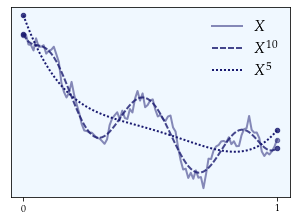

In [5]:
# Retain the first simulation only
X,xK = X[:,[0]],xK[:,[0]]  
K_   = int(KMax/2)
xK_  = reconstructPath(Sig[:K_,[0]]) # decrease truncation level

save = 1; colX = "midnightblue"

fig,ax = plt.subplots(1,1,figsize = (5,3.5)); ax.set_facecolor("aliceblue")
# Original path
ax.plot(ts,X,lw = 2,color = colX,label = r"$X$",alpha = 0.5,zorder = -2) 
ax.scatter(ts[[0,-1]],X[[0,-1]],s = 20,color = colX,alpha = 0.5)
# Projected path
ax.plot(ts,xK, dashes = (3,1),lw = 2,color = colX,label = r"$X^{%d}$"%KMax,alpha = 0.8)
ax.scatter(ts[[0,-1]],xK[[0,-1]],s = 20,color = colX,alpha = 0.8)
# Projected path (fewer basis functions)
ax.plot(ts,xK_,dashes = (1,1),lw = 2,color = colX,label = r"$X^{%d}$"%K_)
ax.scatter(ts[[0,-1]],xK_[[0,-1]],s = 20,color = colX,alpha = 0.8)
ax.set_xticks([0,T]); ax.set_yticks([])
ax.legend(loc = 'best',fontsize = 15,frameon=False)
if save: plt.savefig("Figures/pathReconstruction.pdf",dpi = 500,bbox_inches ="tight",pad_inches = 0.15)
plt.show()